# Pulse Function Tests - New Independent Pulse System

This notebook tests the new pulse system that is independent of AtomicSystem:
- `envelope_type` parameter in `Pulse` class: 'cos2' or 'gaussian'
- `pulse_peak_time` = time where envelope is maximal
- `pulse_fwhm` = Full Width at Half Maximum parameter
- Pulse exists only in `[t_peak - fwhm, t_peak + fwhm]`
- Each pulse carries its own parameters (frequency, amplitude, fwhm, type)

Test scenarios:
- Envelope type comparison using plotting functions
- Independent pulse parameter control
- Fourier Transform spectral comparison
- New LaserPulseSequence factory methods

In [1]:
# =============================
# IMPORT NECESSARY MODULES
# =============================
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Import matplotlib settings
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from qspectro2d.config import COLORS, LINE_STYLES, MARKERS

# Import from our project
from qspectro2d.core import LaserPulseSequence, LaserPulse
from qspectro2d.core import identify_non_zero_pulse_regions
from qspectro2d.core import (
    pulse_envelope, Epsilon_pulse, E_pulse
)
from qspectro2d.visualization import (
    plot_pulse_envelope, plot_e_pulse, plot_epsilon_pulse, plot_all_pulse_components
)

## Test 1: New Independent Pulse System - Easy Switching Between Types

Demonstrate how to easily create pulse sequences with different envelope types using the new independent system and built-in plotting functions.

NEW PULSE SYSTEM COMPARISON: COS² vs GAUSSIAN
Pulse envelope types:
  Cos2: type='cos2', freq=0.0, fwhm=2.0, amp=1.0
  Gaussian: type='gaussian', freq=0.0, fwhm=2.0, amp=1.0

NEW SYSTEM BENEFITS:
✓ Independent pulse parameters
✓ Easy envelope type switching
✓ Clean plotting function integration
✓ No AtomicSystem dependency for pulse creation


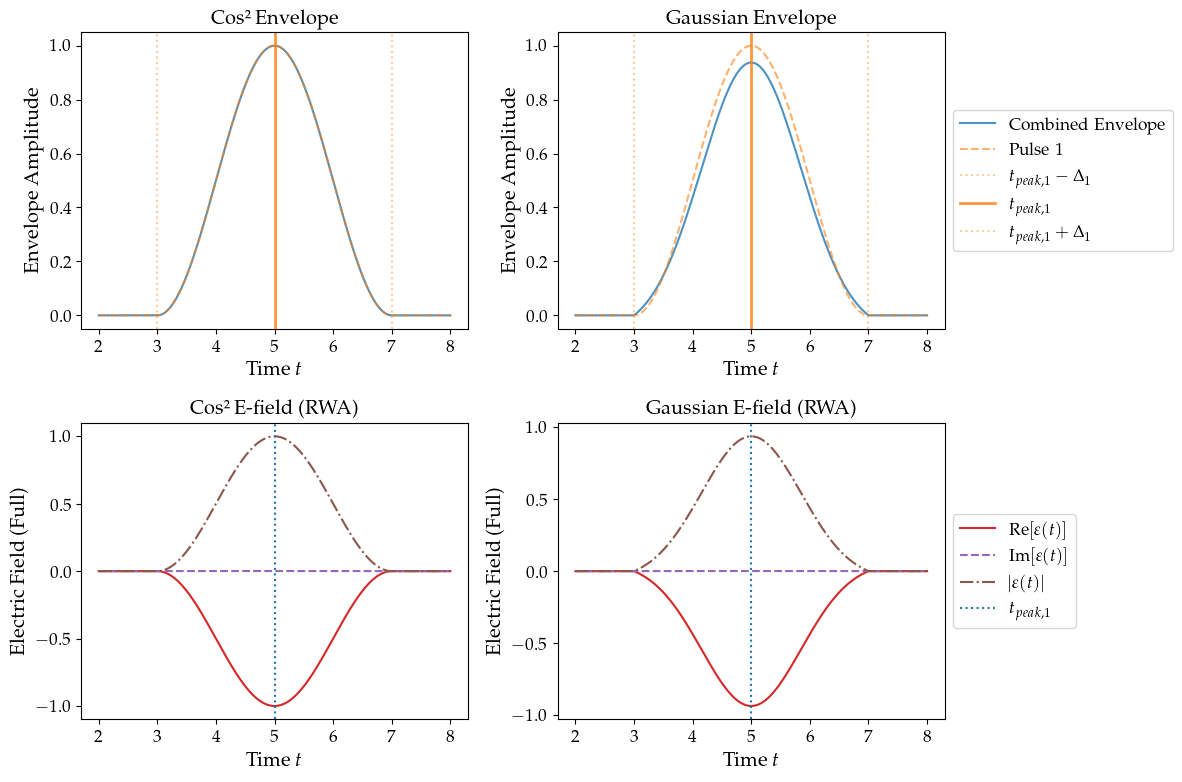

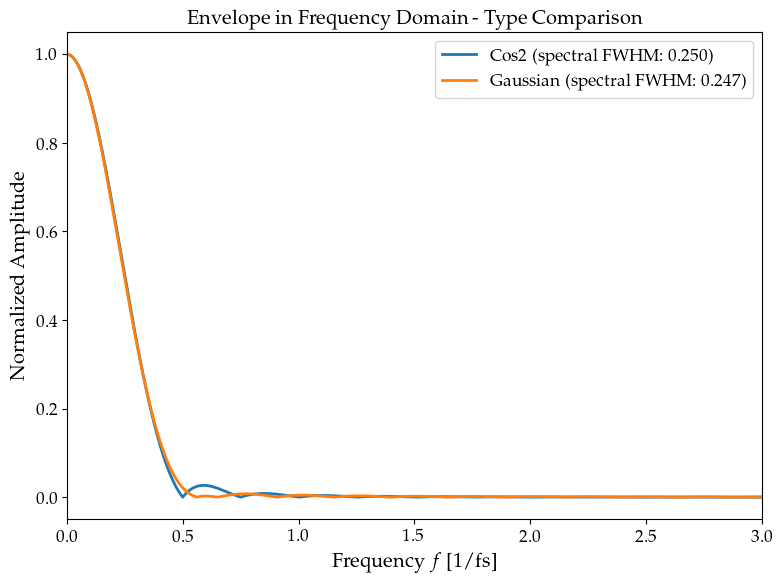

In [2]:
# =============================
# NEW INDEPENDENT PULSE SYSTEM DEMONSTRATION
# =============================
from cmath import phase


print("NEW PULSE SYSTEM COMPARISON: COS² vs GAUSSIAN")

### Setup parameters
t_peak    = 5.0
fwhm      = 2.0
amplitude = 1.0
frequency = 1.0
phase     = np.pi

### Create pulse sequences with different envelope types
pulse_seqs = {
    'cos2': LaserPulseSequence.from_general_specs(
        pulse_peak_times=t_peak,
        pulse_phases=phase,
        pulse_freqs=frequency,
        pulse_fwhms=fwhm,
        pulse_amplitudes=amplitude,
        envelope_types='cos2'
    ),
    'gaussian': LaserPulseSequence.from_general_specs(
        pulse_peak_times=t_peak,
        pulse_phases=phase,
        pulse_freqs=frequency,
        pulse_fwhms=fwhm,
        pulse_amplitudes=amplitude,
        envelope_types='gaussian'
    )
}

print("Pulse envelope types:")
for name, seq in pulse_seqs.items():
    pulse = seq.pulses[0]
    print(f"  {name.capitalize()}: type='{pulse.envelope_type}', "
          f"freq={pulse.pulse_freq:.1f}, "
          f"fwhm={pulse.pulse_fwhm:.1f}, "
          f"amp={pulse.pulse_amplitude:.1f}")

### Time domain for visualization and analysis
times = np.linspace(t_peak-1.5*fwhm, t_peak+1.5*fwhm, 1000)

# =============================
# SIMPLIFIED PLOTTING USING BUILT-IN FUNCTIONS
# =============================

### Compare envelope types using plotting functions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

### Plot cos2 envelope
plot_pulse_envelope(times, pulse_seqs['cos2'], ax=axes[0, 0], show_legend=False)
axes[0, 0].set_title('Cos² Envelope')

### Plot gaussian envelope  
plot_pulse_envelope(times, pulse_seqs['gaussian'], ax=axes[0, 1])
axes[0, 1].set_title('Gaussian Envelope')

### Plot cos2 E-field (RWA)
plot_epsilon_pulse(times, pulse_seqs['cos2'], ax=axes[1, 0], show_legend=False)
axes[1, 0].set_title('Cos² E-field (RWA)')

### Plot gaussian E-field (RWA)
plot_epsilon_pulse(times, pulse_seqs['gaussian'], ax=axes[1, 1])
axes[1, 1].set_title('Gaussian E-field (RWA)')

plt.tight_layout()

# =============================
# FREQUENCY DOMAIN COMPARISON
# =============================
dt = 0.1  # fs
t_spectral = np.arange(0, 300, dt)
N = len(t_spectral)

plt.figure()

for i, (name, seq) in enumerate(pulse_seqs.items()):
    ### Calculate FFT of envelope
    spectral_env = np.array([pulse_envelope(t, seq) for t in t_spectral])
    fft = np.fft.fft(spectral_env)
    freq = np.fft.fftfreq(N, dt)
    
    ### Process positive frequencies
    pos_idx = freq >= 0
    spectrum = np.abs(fft[pos_idx])
    spectrum /= np.max(spectrum)
    
    ### Find spectral FWHM
    above_half = np.where(spectrum >= 0.5)[0]
    fwhm_freq = freq[pos_idx][above_half[-1]] - freq[pos_idx][above_half[0]] if len(above_half) > 0 else 0
    
    color = f'C{i}'
    plt.plot(freq[pos_idx], spectrum, 
             label=f'{name.capitalize()} (spectral FWHM: {fwhm_freq:.3f})',
             color=color, linewidth=2)

plt.xlim(0, 3)
plt.xlabel(r'Frequency $f$ [1/fs]')
plt.ylabel('Normalized Amplitude')
plt.title('Envelope in Frequency Domain - Type Comparison')
plt.legend()
plt.tight_layout()

print("\nNEW SYSTEM BENEFITS:")
print("✓ Independent pulse parameters")
print("✓ Easy envelope type switching")
print("✓ Clean plotting function integration")
print("✓ No AtomicSystem dependency for pulse creation")

# Test 2: Comprehensive Pulse Analysis with Plotting Functions

Created complex pulse sequence:
  Pulse 0: t_peak=0.0, freq=0.0, fwhm=1.0, amp=1.0
  Pulse 1: t_peak=3.0, freq=0.0, fwhm=1.2, amp=1.5
  Pulse 2: t_peak=6.0, freq=0.0, fwhm=0.8, amp=0.8

Using plot_all_pulse_components for comprehensive analysis...


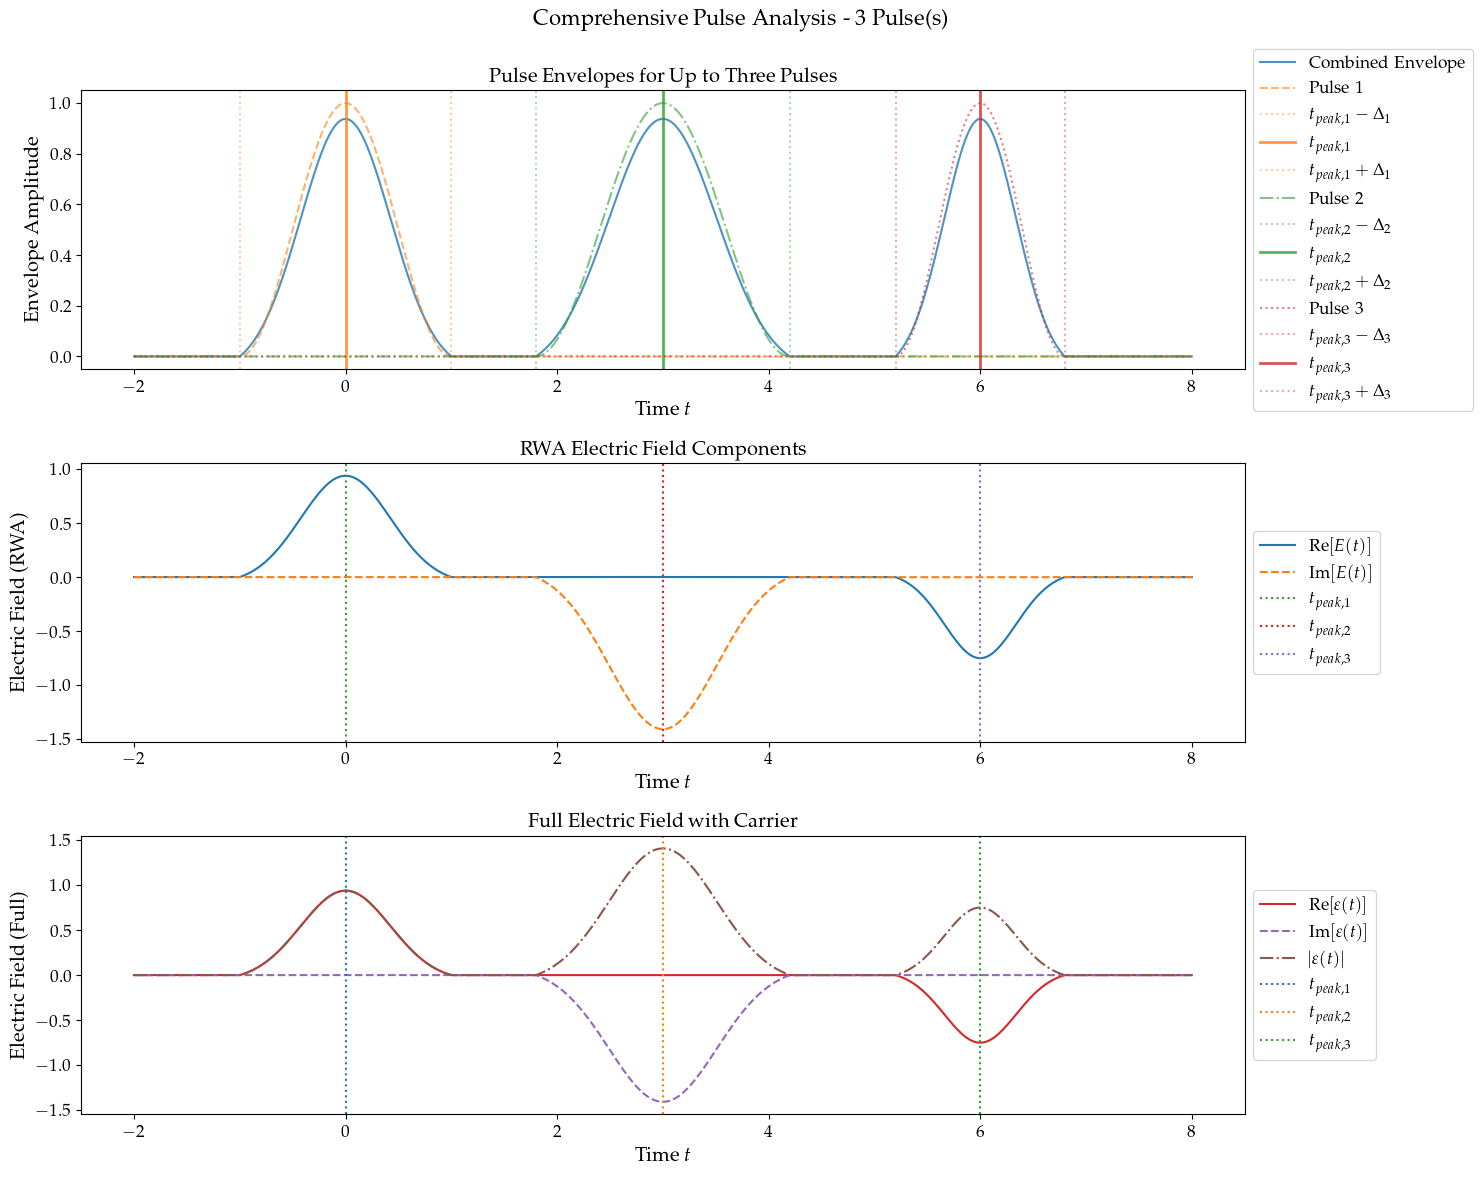

In [3]:
# =============================
# TEST: Multi-pulse sequence with plotting functions
# =============================

### Create complex pulse sequence with individual parameters
test_times = np.linspace(-2, 8, 500)

complex_pulse_seq = LaserPulseSequence.from_general_specs(
    pulse_indices=[0, 1, 2],
    pulse_peak_times=[0.0, 3.0, 6.0],
    pulse_phases=[0.0, 1.57, 3.14],
    pulse_freqs=[1.0, 1.1, 0.9],        # Different frequencies
    pulse_fwhms=[1.0, 1.2, 0.8],        # Different FWHMs
    pulse_amplitudes=[1.0, 1.5, 0.8],   # Different amplitudes
    envelope_types='gaussian'
)

print("Created complex pulse sequence:")
for i, pulse in enumerate(complex_pulse_seq.pulses):
    print(f"  Pulse {i}: t_peak={pulse.pulse_peak_time:.1f}, "
          f"freq={pulse.pulse_freq:.1f}, "
          f"fwhm={pulse.pulse_fwhm:.1f}, "
          f"amp={pulse.pulse_amplitude:.1f}")

# =============================
# USE ALL-IN-ONE PLOTTING FUNCTION
# =============================

### Plot all pulse components using built-in function
print("\nUsing plot_all_pulse_components for comprehensive analysis...")
fig = plot_all_pulse_components(test_times, complex_pulse_seq, figsize=(15, 12))

Overlap sequence contains 4 pulses:
  Pulse 0 (type 0): t_peak=1.0, amp=1.0
  Pulse 1 (type 1): t_peak=3.0, amp=1.5
  Pulse 2 (type 0): t_peak=5.0, amp=1.0
  Pulse 3 (type 2): t_peak=7.0, amp=2.0
✓ E0 calculation and region analysis completed
✓ Demonstrated: Pulse overlap detection and field strength calculation


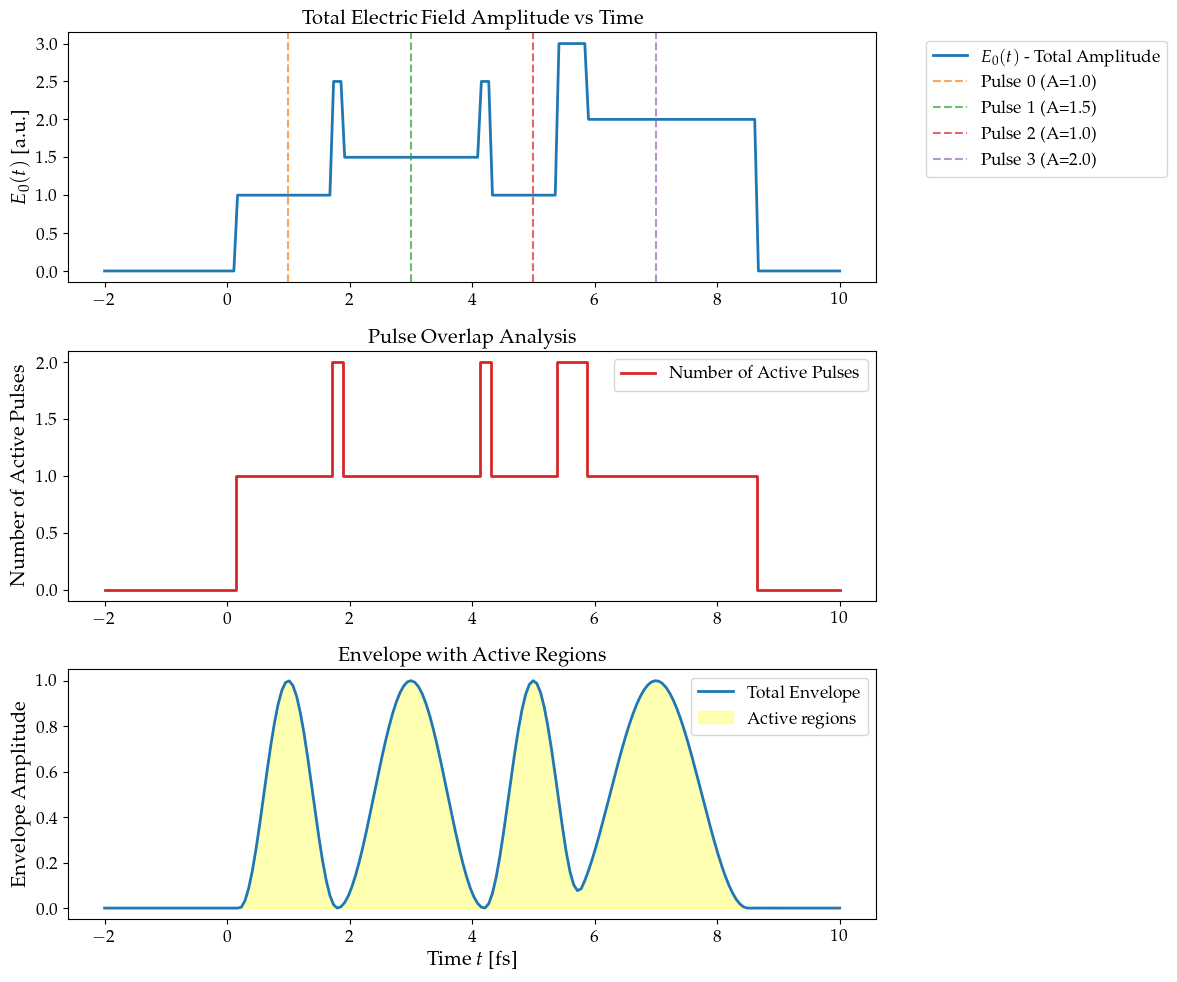

In [4]:
# Test 3: Pulse Regions and E0 Calculation
# =============================
# TEST: E0 calculation and pulse regions
# =============================

### Create overlapping pulse sequence for E0 testing
overlap_times = np.linspace(-2, 10, 200)

overlap_seq = LaserPulseSequence.from_general_specs(
    pulse_indices=[0, 1, 0, 2],  # Reuse pulse types
    pulse_peak_times=[1.0, 3.0, 5.0, 7.0],
    pulse_phases=[0.0, 1.57, 3.14, 0.5],
    pulse_freqs=[1.0, 1.2, 1.0, 0.8],      
    pulse_fwhms=[0.8, 1.2, 0.8, 1.5],       
    pulse_amplitudes=[1.0, 1.5, 1.0, 2.0], 
    envelope_types='cos2'
)

print(f"Overlap sequence contains {len(overlap_seq.pulses)} pulses:")
for i, pulse in enumerate(overlap_seq.pulses):
    print(f"  Pulse {i} (type {pulse.pulse_index}): "
          f"t_peak={pulse.pulse_peak_time:.1f}, "
          f"amp={pulse.pulse_amplitude:.1f}")

# =============================
# E0 ANALYSIS WITH SIMPLIFIED PLOTTING
# =============================

### Calculate E0 and active pulse information
E0_values = np.array([overlap_seq.get_total_amplitude_at_time(t) for t in overlap_times])
num_active = np.array([overlap_seq.get_field_info_at_time(t)['num_active_pulses'] 
                      for t in overlap_times])

### Active regions analysis
active_regions = identify_non_zero_pulse_regions(overlap_times, overlap_seq)
envelope_values = pulse_envelope(overlap_times, overlap_seq)

plt.figure(figsize=(12, 10))

### Plot E0 vs time with pulse markers
plt.subplot(3, 1, 1)
plt.plot(overlap_times, E0_values, 'C0-', linewidth=2, label=r'$E_0(t)$ - Total Amplitude')

for i, pulse in enumerate(overlap_seq.pulses):
    plt.axvline(pulse.pulse_peak_time, color=f'C{i+1}', linestyle='--', alpha=0.7,
                label=f'Pulse {i} (A={pulse.pulse_amplitude:.1f})')

plt.ylabel(r'$E_0(t)$ [a.u.]')
plt.title('Total Electric Field Amplitude vs Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### Plot number of active pulses
plt.subplot(3, 1, 2)
plt.step(overlap_times, num_active, 'C3-', linewidth=2, where='mid', 
         label='Number of Active Pulses')
plt.ylabel('Number of Active Pulses')
plt.title('Pulse Overlap Analysis')
plt.legend()

### Plot envelope with active regions highlighted
plt.subplot(3, 1, 3)
plt.plot(overlap_times, envelope_values, 'C0-', linewidth=2, label='Total Envelope')
plt.fill_between(overlap_times, envelope_values, where=active_regions, 
                 color='yellow', alpha=0.3, label='Active regions')

plt.xlabel(r'Time $t$ [fs]')
plt.ylabel('Envelope Amplitude')
plt.title('Envelope with Active Regions')
plt.legend()

plt.tight_layout()

print("✓ E0 calculation and region analysis completed")
print("✓ Demonstrated: Pulse overlap detection and field strength calculation")

Testing advanced plotting with diverse parameters:
  Pulse 0: t=0.0, φ=0.00, ω=0.0, fwhm=1.5, A=2.0
  Pulse 1: t=4.0, φ=2.00, ω=0.0, fwhm=1.0, A=1.0
  Pulse 2: t=8.0, φ=4.00, ω=0.0, fwhm=1.2, A=1.8

Advanced plotting demonstrations:
1. Advanced envelope analysis...
2. Complex E-field analysis...
3. Full field analysis...
4. Complete comprehensive analysis...
✓ Advanced plotting capabilities demonstrated
✓ All plotting functions integrate seamlessly with new pulse system
✓ Notebook significantly simplified using built-in plotting functions


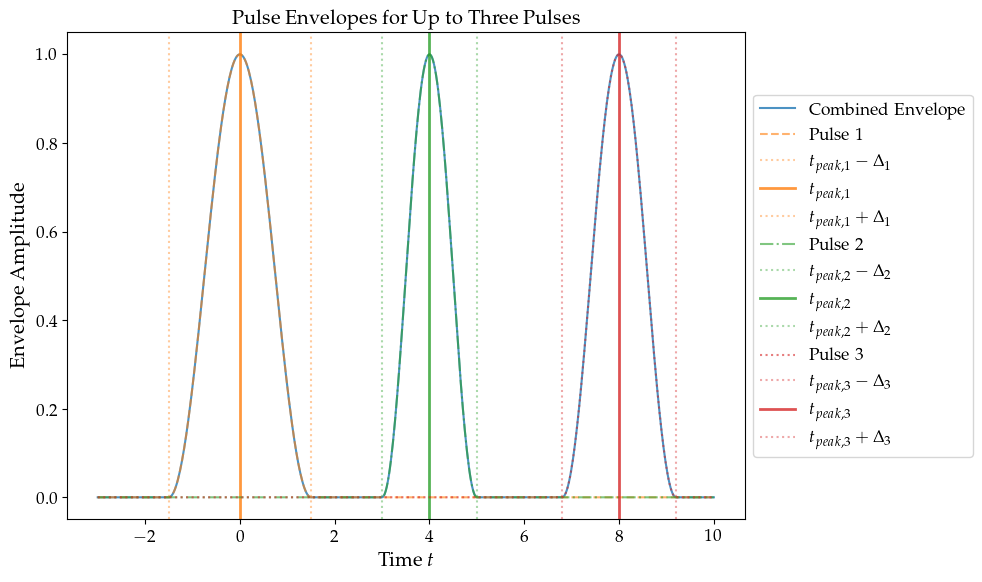

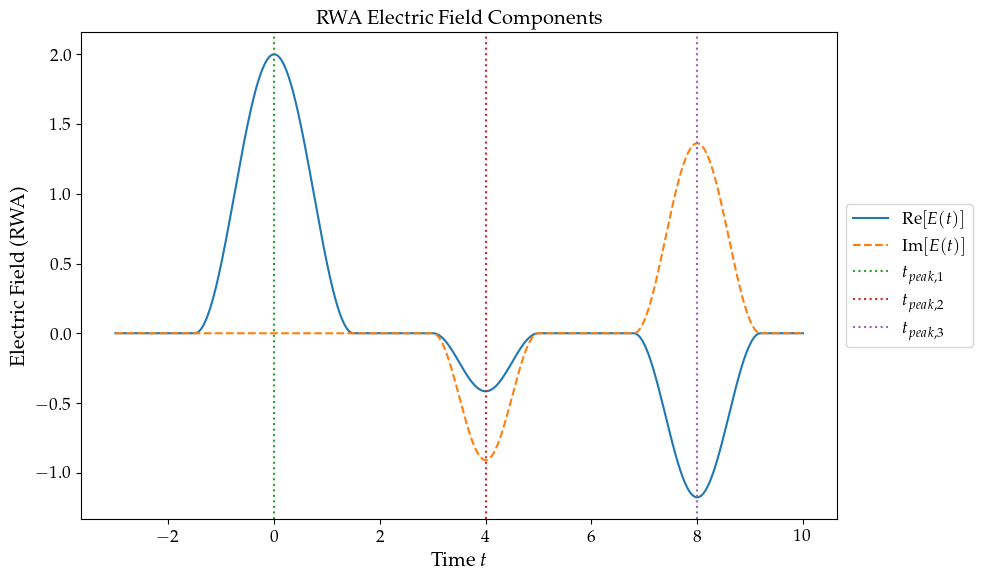

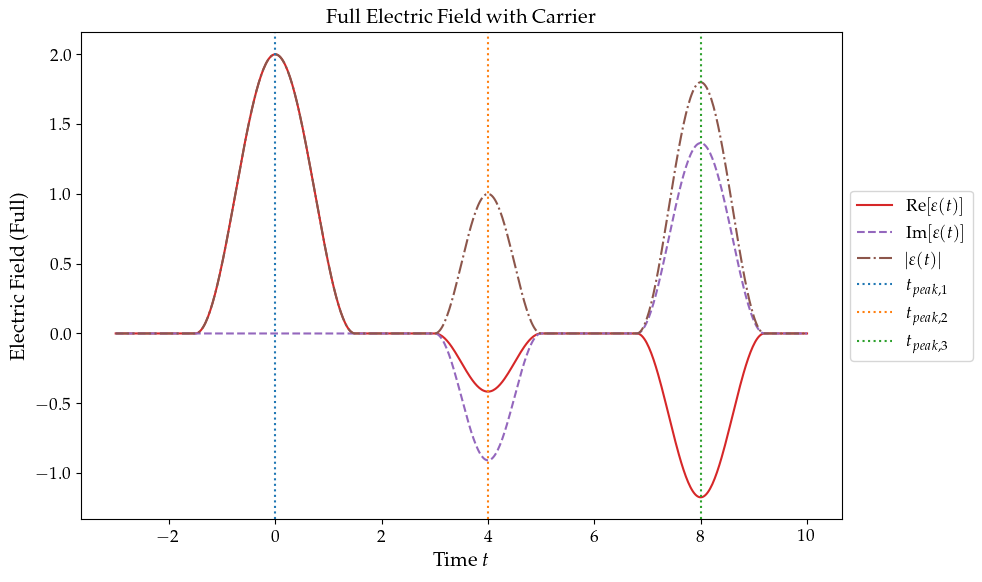

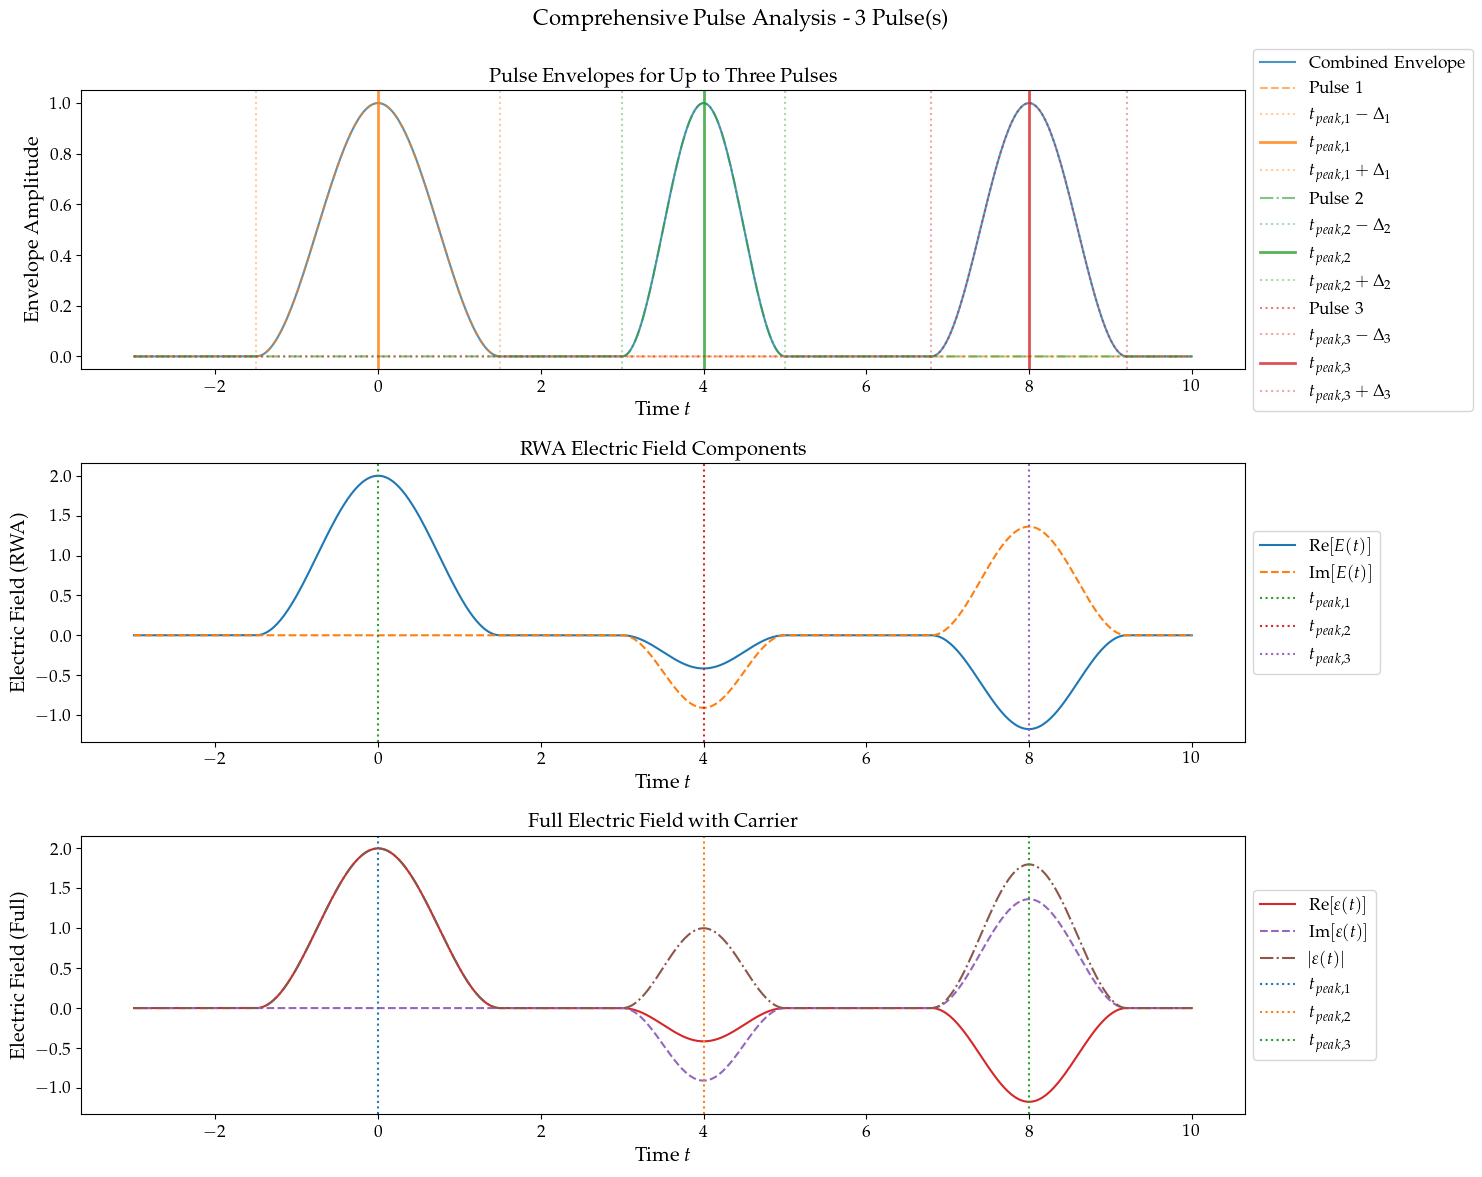

In [5]:
# =============================
# TEST: Advanced plotting capabilities
# =============================

### Create diverse test sequence for advanced plotting
advanced_times = np.linspace(-3, 10, 600)

advanced_seq = LaserPulseSequence.from_general_specs(
    pulse_peak_times=[0.0, 4.0, 8.0],
    pulse_phases=[0.0, 2.0, 4.0],
    pulse_freqs=[0.8, 1.0, 1.2],
    pulse_fwhms=[1.5, 1.0, 1.2],
    pulse_amplitudes=[2.0, 1.0, 1.8],
    envelope_types='cos2'
)

print("Testing advanced plotting with diverse parameters:")
for i, pulse in enumerate(advanced_seq.pulses):
    print(f"  Pulse {i}: t={pulse.pulse_peak_time:.1f}, "
          f"φ={pulse.pulse_phase:.2f}, "
          f"ω={pulse.pulse_freq:.1f}, "
          f"fwhm={pulse.pulse_fwhm:.1f}, "
          f"A={pulse.pulse_amplitude:.1f}")

### Demonstrate different plotting options
print("\nAdvanced plotting demonstrations:")

### 1. Envelope comparison with different parameters
print("1. Advanced envelope analysis...")
fig_env = plot_pulse_envelope(advanced_times, advanced_seq)

### 2. Complex field analysis
print("2. Complex E-field analysis...")
fig_e = plot_e_pulse(advanced_times, advanced_seq)

### 3. Full field with carrier
print("3. Full field analysis...")
fig_eps = plot_epsilon_pulse(advanced_times, advanced_seq)

### 4. Complete analysis in one plot
print("4. Complete comprehensive analysis...")
fig_all = plot_all_pulse_components(advanced_times, advanced_seq)

print("✓ Advanced plotting capabilities demonstrated")
print("✓ All plotting functions integrate seamlessly with new pulse system")
print("✓ Notebook significantly simplified using built-in plotting functions")

In [6]:
# Test solver options and qutip functionality (unchanged)
final_solver_options = {
    "store_states": True,
    "store_final_state": False,
}
from qutip import *
import numpy as np

def test(
    arg_1: float,
    solver_options: dict = None,
) -> None:
    print("Testing solver options with custom parameters...")
    print(f"solver_options: {solver_options}")
    options = solver_options.copy() if solver_options else {}
    print(f"options: {options}")

    # Add default options if not already present
    default_options = {
        "progress_bar": "",
        "rtol": 1e-4,
    }

    # Update options with defaults only if not already set
    for key, value in default_options.items():
        if key not in options:
            options[key] = value
    print(f"Final options: {options}")

# test(1.0, final_solver_options)

psi0 = ket2dm(basis(2, 0))  # Initial state
H = sigmax()  # Hamiltonian (example)
tlist = np.linspace(0, 10, 10000)  # Time list for simulation
result = mesolve(H, psi0, tlist, [], [sigmax(), sigmay(), sigmaz()],
                 options=final_solver_options)
result_ = result 
print(result, result_)

/home/leopold/miniconda3/envs/master_env/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


<Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0003077983856201172
    preparation time: 0.0003268718719482422
    run time: 0.42191076278686523
    solver: 'Master Equation Evolution'
    num_collapse: 0
  Time interval: [0.0, 10.0] (10000 steps)
  Number of e_ops: 3
  States saved.
> <Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0003077983856201172
    preparation time: 0.0003268718719482422
    run time: 0.42191076278686523
    solver: 'Master Equation Evolution'
    num_collapse: 0
  Time interval: [0.0, 10.0] (10000 steps)
  Number of e_ops: 3
  States saved.
>


In [7]:
# Test polarization calculation (may need AtomicSystem for dip_op)
from qspectro2d.spectroscopy.calculations import complex_polarization
from qspectro2d.core.atomic_system.system_class import AtomicSystem

# Note: AtomicSystem still needed for physical operators like dip_op
# Only pulse creation is now independent
test_system = AtomicSystem()
Dip = test_system.dip_op
polarization = complex_polarization(Dip, result.states)
times = result.times

print("✓ Polarization calculation works (AtomicSystem still needed for operators)")

✓ Polarization calculation works (AtomicSystem still needed for operators)


In [8]:
# Test inhomogeneity sampling (unchanged)
from qspectro2d.spectroscopy.inhomogenity import sample_from_gaussian

n_freqs = 10
D = 2
x0 = 60
freq_samples = (
    sample_from_gaussian(n_freqs, D, x0),
    sample_from_gaussian(n_freqs, D, x0),
)

for i in range(n_freqs):
    print(f"Sample {i}: {freq_samples[0][i]:.2f}, {freq_samples[1][i]:.2f}")

print("✓ Inhomogeneity sampling works independently")

Sample 0: 60.13, 59.25
Sample 1: 59.83, 60.92
Sample 2: 59.93, 59.29
Sample 3: 61.08, 60.97
Sample 4: 58.65, 60.38
Sample 5: 59.79, 60.53
Sample 6: 59.43, 60.44
Sample 7: 59.81, 59.78
Sample 8: 59.96, 60.20
Sample 9: 59.48, 59.78
✓ Inhomogeneity sampling works independently
